#  Data Metrics/dimensions 

__[Apache Spark](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.approxQuantile)__

In [1]:
#---------------------------------------- **START** ---------------------------------------
# _author_ = Johnleonard C.O
# _Date_ = 4/29/2020

import os
import findspark
findspark.init()
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("PythonSQLAPP").master("local[5]").config('spark.cores.max', 5).getOrCreate()
"""
Data file -> File path to the main Yellow trip data 2019

LookupFile -> File path to the LocationID lookup file to better understand the locations rather than 
having them as id's
"""

DataFile = r"file:///" + os.getcwd() + os.sep + "yellow_tripdata_2019-09.csv"
LookupFile = r"file:///" + os.getcwd() + os.sep + "taxi+_zone_lookup.csv"

taxiDf = spark.read.csv(DataFile, header=True, inferSchema=True)
lookupDf = spark.read.csv(LookupFile, header=True, inferSchema=True)



# get total row of main data df
count = taxiDf.count()
print("yellow_tripdata_2019-09 Row count -> ", count)

# Show your PySpark Dataframe
taxiDf.show(4)
lookupDf.show(4)

yellow_tripdata_2019-09 Row count ->  6567788
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       1| 2019-09-01 00:06:48|  2019-09-01 00:25:46|              1|          2.0|         1|                 N|         186|         161|           2|       13.0|  3.0|    0.5

# Data Missingness :

- There are no missing values in the datasets

In [2]:
# Check data missingness
from pyspark.sql.functions import isnan, when, count, col

taxiDf.select([count(when(isnan(c), c)).alias(c) for c in taxiDf.columns]).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       0|                   0|                    0|              0|            0|         0|                 0|           0|           0|           0|          0|    0|      0|         0|           0|                    0

# Data Column summary/Dataset Overview :

In [3]:
# Schema of PySpark Dataframe

taxiDf.printSchema()

for col in taxiDf.columns:
    taxiDf.describe([col]).show()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)

+-------+------------------+
|summary|          VendorID|
+-------+------------------+
|  count|           6533699|
|   mean|1.6488327668599365|
| stddev|0.4773601560666985|

## Region Analysis :

1. Which region have the most pickups with graph representation
2. Which region have the most drop off with graph representaion
    
    In the tables below, we can see that in the first half of 2017,

    - The top 3 pickup zones are : Upper East Side, Midtown Center, Penn Station all in Manhattan (followed by one in Queens)
    - The top 3 drop-off are :  Upper East Side, Midtown Center also in Manhattan (So much love for Manhattan :3)


+---------+--------------------+------+
|PUBorough|              PUZone| count|
+---------+--------------------+------+
|Manhattan|Upper East Side S...|284765|
|Manhattan|Upper East Side N...|260570|
|Manhattan|      Midtown Center|244226|
|Manhattan|Penn Station/Madi...|241464|
|   Queens|         JFK Airport|241462|
|Manhattan|        Midtown East|227037|
+---------+--------------------+------+
only showing top 6 rows

+-------------+-------+
|    PUBorough|  count|
+-------------+-------+
|    Manhattan|5934470|
|       Queens| 482738|
|     Brooklyn|  81022|
|      Unknown|  56672|
|        Bronx|  11828|
|          EWR|    797|
|Staten Island|    261|
+-------------+-------+



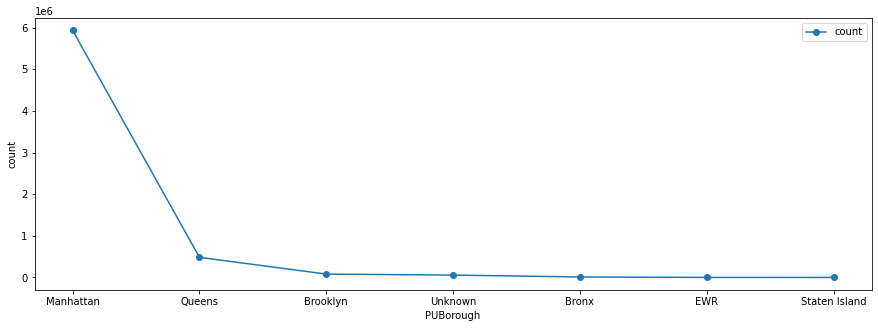

In [5]:
# Lookup file for PUlocation and DOlocation to better understand the data rether than using the location id
# Which regions have most pickups and drop-offs?

import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, col, split
# -------------------------------------------------------------------

# PULocationID -> start
taxi_PULocationID = taxiDf.select(
    split(
        split(
            col("tpep_pickup_datetime"), ':').getItem(0), " " ).getItem(1).alias("tpep_pickup_hour"),
    col('PULocationID').alias('LocationID')
 )
taxi_PULocationID = taxi_PULocationID.join(lookupDf, on="LocationID", how='inner')
taxi_PULocationID = taxi_PULocationID.withColumnRenamed(
	"Borough",
	"PUBorough"
).withColumnRenamed(
	"Zone",
	"PUZone"
).withColumnRenamed(
	"service_zone",
	"PU_service_zone"
)



# -------------------------------------------------------------------
# taxi_PULocationID.show(2)
# ---------------------------------------------
# count
taxi_PULocationID.groupby("PUBorough", "PUZone").count().sort(col("count").desc()).show(6)

PUBorough_count = taxi_PULocationID.groupby("PUBorough").count().sort(col("count").desc())
PUBorough_count.show()

PULocationID_df = PUBorough_count.toPandas()
pu_graph = PULocationID_df.plot(x='PUBorough', y=['count'], kind='line', style="-o", figsize=(15,5))
pu_graph.set_ylabel("count")
plt.show()




+---------+--------------------+------+
|DOBorough|              DOZone| count|
+---------+--------------------+------+
|Manhattan|Upper East Side N...|272784|
|Manhattan|Upper East Side S...|257288|
|Manhattan|      Midtown Center|231114|
|Manhattan|         Murray Hill|205629|
|Manhattan|Times Sq/Theatre ...|196686|
|Manhattan|        Midtown East|187917|
+---------+--------------------+------+
only showing top 6 rows

+-------------+-------+
|    DOBorough|  count|
+-------------+-------+
|    Manhattan|5785525|
|       Queens| 369016|
|     Brooklyn| 281778|
|      Unknown|  68122|
|        Bronx|  45820|
|          EWR|  15636|
|Staten Island|   1891|
+-------------+-------+



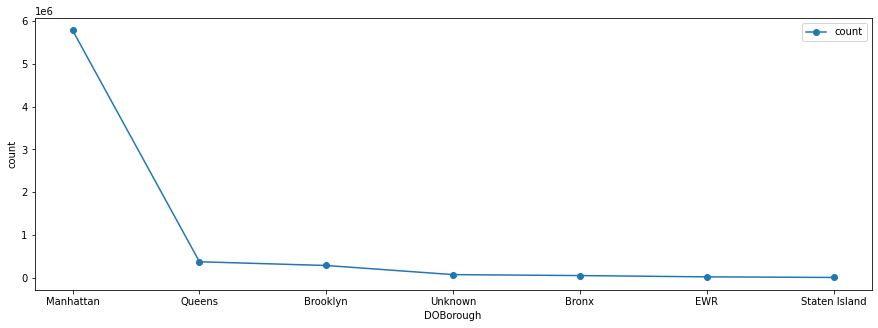

In [6]:
# -------------------------------------------------------------------

# DOLocationID -> start
taxi_DOLocationID = taxiDf.select(
    split(
        split(
            col(
                "tpep_dropoff_datetime"), ':').getItem(0), " " ).getItem(1).alias("tpep_dropoff_hour"),
    col("DOLocationID").alias("LocationID")
)
taxi_DOLocationID = taxi_DOLocationID.join(lookupDf, on="LocationID", how='inner')
taxi_DOLocationID = taxi_DOLocationID.withColumnRenamed(
	"Borough",
	"DOBorough"
).withColumnRenamed(
	"Zone",
	"DOZone"
).withColumnRenamed(
	"service_zone",
	"DO_service_zone"
)


# -------------------------------------------------------------------
# group by [DOBorough] and count
taxi_DOLocationID.groupby("DOBorough", "DOZone").count().sort(col("count").desc()).show(6)

DOBorough_count = taxi_DOLocationID.groupby("DOBorough").count().sort(col("count").desc())
DOBorough_count.show()
# ---------------------------------------------

#Convert to pandas to plot
# graph
DOLocationID_df = DOBorough_count.toPandas()
Do_graph = DOLocationID_df.plot(x='DOBorough', y=['count'], kind='line', style="-o", figsize=(15,5))
Do_graph.set_ylabel("count")
plt.show()

# -------------------------------------------------------------------




## Time Analysis

1. tpep_pickup hour
2. tpep_dropoff hour

    As you can see, according to the NYC Taxi records from 2019 sept, it is found that
   - The peak hours are around 5PM ~ 7PM.
   - The off-peak hours are around 3AM ~ 5AM.

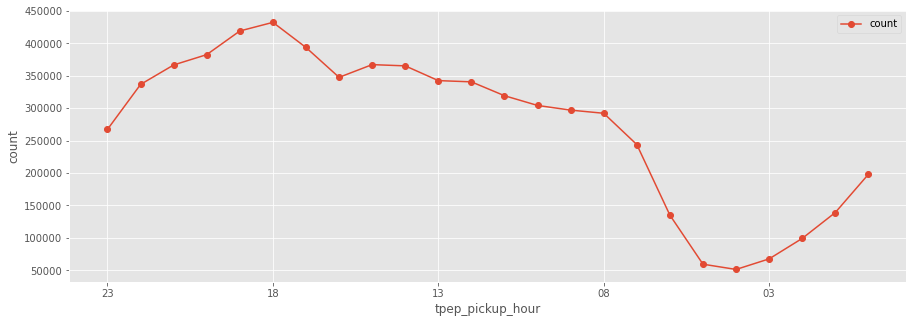

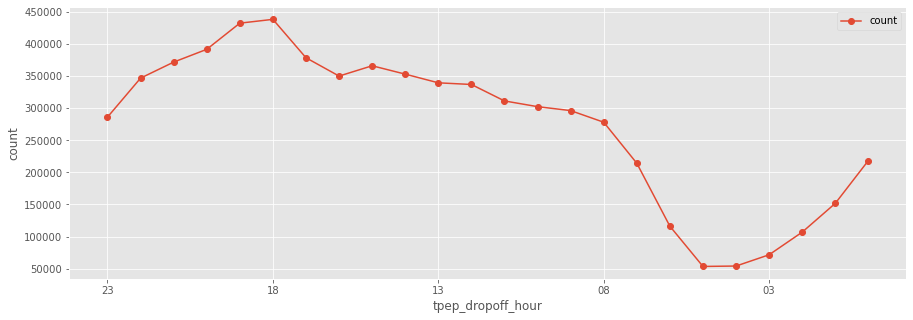

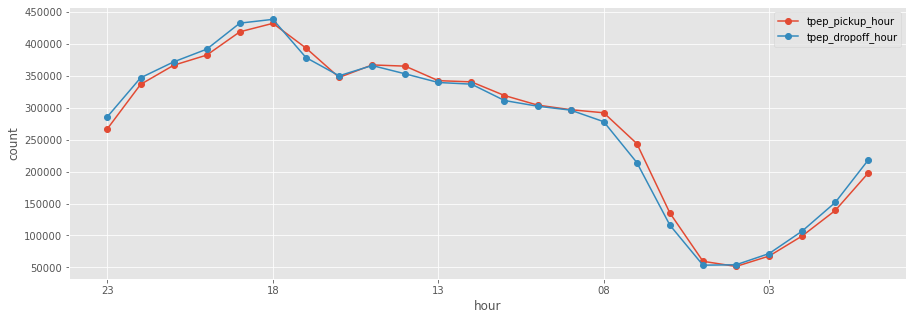

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

pu_hour = taxi_PULocationID.groupby("tpep_pickup_hour").count().sort(col("tpep_pickup_hour").desc()).toPandas()

do_hour = taxi_DOLocationID.groupby("tpep_dropoff_hour").count().sort(col("tpep_dropoff_hour").desc()).toPandas()



ax = pu_hour.plot(x='tpep_pickup_hour', y=['count'], kind='line', style="-o", figsize=(15,5))
ax.set_ylabel("count")
plt.show()


ay = do_hour.plot(x='tpep_dropoff_hour', y=['count'], kind='line', style="-o", figsize=(15,5))
ay.set_ylabel("count")
plt.show()


#-----------------------------------OVERLAY --------------------

ax = pu_hour.plot(x='tpep_pickup_hour', y=['count'], kind='line', style="-o", figsize=(15,5))
do_hour.plot(x='tpep_dropoff_hour', y=['count'], kind='line', style="-o", figsize=(15,5), ax=ax)
ax.set_ylabel("count")
ax.set_xlabel("hour")
ax.legend(["tpep_pickup_hour", "tpep_dropoff_hour"])
plt.show()

## Vendor

Vendor_id takes on only three values that is <blockquote> 1, 2, 4 </blockquote> 
<b>This could represent data from two different taxi companies where Vendor_id num 2 has the most record count so far.</b>

'---' 

Text(0.5, 1.0, 'Vendor id agg within the data set')

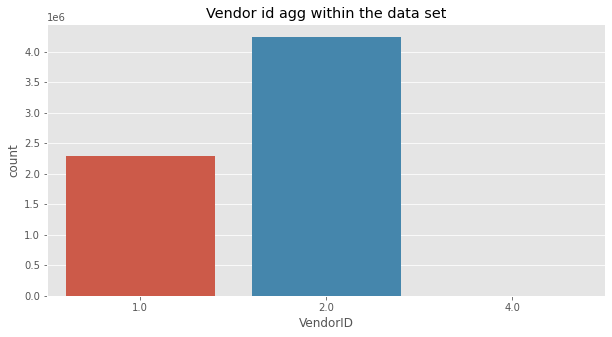

In [8]:
# Distribution of the number of passengers across the vendor_id variables 1 and 2.
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))

vendors_df = taxiDf.select("VendorID", "passenger_count").toPandas()

sns.countplot(x="VendorID", data=vendors_df).set_title(
    "Vendor id agg within the data set"
)

Text(0.5, 1.0, 'Passenger count for Vender id = 1')

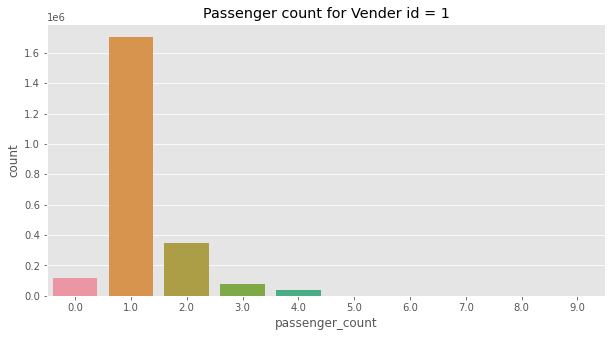

In [9]:
plt.figure(figsize=(10,5))

sns.countplot(x="passenger_count", data=vendors_df[vendors_df["VendorID"] == 1]).set_title(
    "Passenger count for Vender id = 1"
)

Text(0.5, 1.0, 'Passenger count for Vender id = 2')

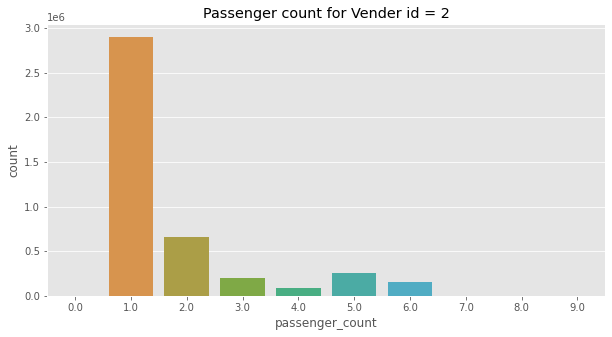

In [10]:
plt.figure(figsize=(10,5))

sns.countplot(x="passenger_count", data=vendors_df[vendors_df["VendorID"] == 2]).set_title(
    "Passenger count for Vender id = 2"
)

Text(0.5, 1.0, 'Passenger count for Vender id = 4')

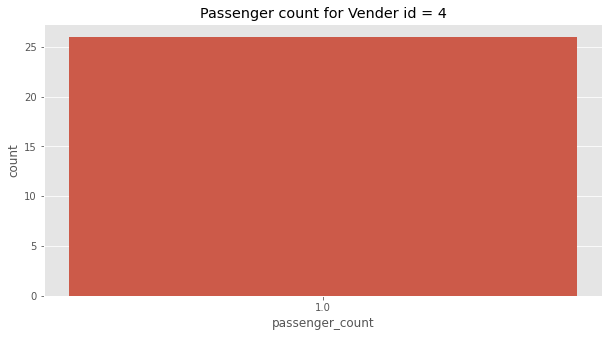

In [11]:
plt.figure(figsize=(10,5))

sns.countplot(x="passenger_count", data=vendors_df[vendors_df["VendorID"] == 4]).set_title(
    "Passenger count for Vender id = 4"
)

## Trip Distance Distribution with in the data set

1. The graph suggests there were quite alot of short trips by taxi drivers in this data set.
2. More of this short trips are 0 miles ~ +-20 miles
3. With the hightest recorded distance to be 604 miles ( I wonder where the person went with a taxi that must cost alot :) )


+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|           6567788|
|   mean| 3.086974002510419|
| stddev|4.0367785378426175|
|    min|               0.0|
|    max|             603.5|
+-------+------------------+



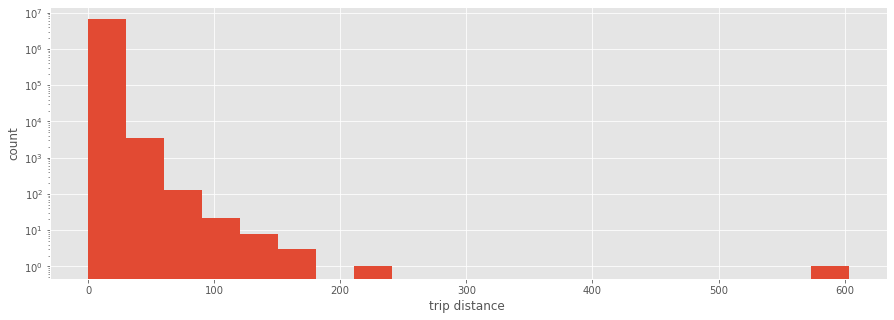

In [12]:

trip_distance = taxiDf.select("trip_distance")
trip_distance.describe(["trip_distance"]).show()


# plotty time
trip_dist_df = trip_distance.toPandas()

ax = trip_dist_df['trip_distance'].hist(bins=20, figsize=(15,5))
ax.set_yscale('log')
ax.set_xlabel("trip distance ")
ax.set_ylabel("count")
plt.show()

# Task 2 -

- Remove trip_distance outliers from provided dataset and calculate top 10 PULocationId,DOLocationId pairs for total_amount. For outliers detection you can use any algorithm that you think is most suitable


#### OUTLIERS DETECTION WITH INTERQUARTILE RANGE

The Interquartile Range method, also known as IQR, was developed by John Widler Turky, an American mathematician best known for development of the FFT algorithm and box plot.

IQR is a measure of statistical dispersion, which is equal to the difference between the 75th percentile and the 25th percentile.

IQR Can also be used to detect outliers in a few easy and straightforward steps:
1. Calculate the 1st quartile Q1.
2. Calculate the 3rd quartile Q3.
3. Calculate IQR=Q3−Q1.
4. Calculate the bounds:
    - Lower bound: Q1 − 1.5 ∗ IQR
    - Upper bound: Q3 + 1.5 ∗ IQR
5. Flag any points outside the bounds as suspected outliers.

Reference :
__[Interquartile Range method](https://en.wikipedia.org/wiki/Interquartile_range)__

In [13]:
import pyspark.sql.functions as f

trip_df = taxiDf.select("trip_distance", "PULocationID", "DOLocationID", "passenger_count")

def flag_outliers(df):
    bounds = {
        c: dict(
            zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], 0))
        ) for c in df.columns
    }
    
    for c in bounds:
        iqr = bounds[c]['q3'] - bounds[c]['q1']
        bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
        bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)
    print('\n', bounds, '\n')
    return df.select(
        "*", 
        *[
            f.when(f.col(c).between(bounds[c]['lower'], bounds[c]['upper']),
            "yes"
        ).otherwise("no").alias(c+"_outlier") 
        for c in df.columns]
        )



trip_flag_outliers = flag_outliers(trip_df).select(
    "trip_distance_outlier",
    "trip_distance", 
    "PULocationID", 
    "DOLocationID", 
    "passenger_count"
)

print("\n ----------------> Data Sample of flagged TRIP_DISTANCE <--------------------- \n ")

trip_flag_outliers.show()




 {'trip_distance': {'q1': 1.0, 'q3': 3.14, 'lower': -2.21, 'upper': 6.35}, 'PULocationID': {'q1': 114.0, 'q3': 233.0, 'lower': -64.5, 'upper': 411.5}, 'DOLocationID': {'q1': 107.0, 'q3': 233.0, 'lower': -82.0, 'upper': 422.0}, 'passenger_count': {'q1': 1.0, 'q3': 2.0, 'lower': -0.5, 'upper': 3.5}} 


 ----------------> Data Sample of flagged TRIP_DISTANCE <--------------------- 
 
+---------------------+-------------+------------+------------+---------------+
|trip_distance_outlier|trip_distance|PULocationID|DOLocationID|passenger_count|
+---------------------+-------------+------------+------------+---------------+
|                  yes|          2.0|         186|         161|              1|
|                  yes|          5.5|         161|         256|              1|
|                  yes|          2.9|         145|         145|              1|
|                  yes|          0.0|         145|         145|              1|
|                  yes|          1.5|          95|     

#### Trip_distance filter (DF with columns PULocationID, DOLocationID, trip_distance)

Filtering outliers using trip_distance_outlier column 
 - trip_distance_outlier -> this columns contains 2 values <b> "YES" </b> -> for trip_distance value is an outliers and <b> "NO" </b> -> for trip_distance value not an outliers 

-------> TOP 10 LOCATION COUNT WITHOUT OUTLIERS AND NO LOCATION PAIRING <------------ 
 
Total pairs Count ----> 766414 

+----------+-------+-------+----------+
|LocationID|PUcount|DOcount|Totolcount|
+----------+-------+-------+----------+
|       132| 207100|  55127|    262227|
|       138| 135530|  74093|    209623|
|       230|  24089|  20959|     45048|
|       161|  18848|  13329|     32177|
|       162|  17122|  13256|     30378|
|        48|  15515|  11274|     26789|
|       170|  12827|  11205|     24032|
|       163|  13108|   9914|     23022|
|       164|  11076|  11451|     22527|
|       231|  11345|  10376|     21721|
+----------+-------+-------+----------+
only showing top 10 rows



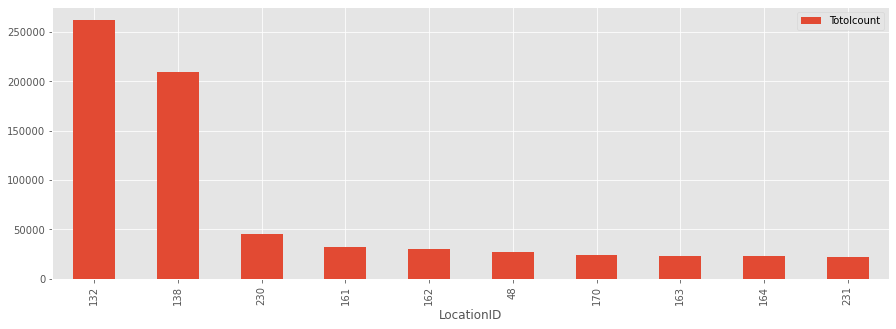

In [82]:
# filter outliers
taxi_trip_no_outliers = trip_flag_outliers.where(f.col("trip_distance_outlier").isin({"no"}))


# split PULocationID and DOLocationID for location aggs
pu_no_outliers = (taxi_trip_no_outliers.select(
    "PULocationID")).groupby(
    "PULocationID").count().withColumnRenamed(
    "PULocationID", "LocationID").withColumnRenamed(
    "count", "PUcount")

do_no_outliers = (taxi_trip_no_outliers.select(
    "DOLocationID")).groupby(
    "DOLocationID").count().withColumnRenamed(
    "DOLocationID", "LocationID").withColumnRenamed(
    "count", "DOcount"
)

pu_do_join = pu_no_outliers.join(do_no_outliers, on=["LocationID"], how='inner')

df = (
    pu_do_join.withColumn(
        'Totolcount', sum(
            pu_do_join[col] for col in (
                pu_do_join.select("DOcount","PUcount")).columns)
    )
).sort(f.desc("Totolcount"))


print("-------> TOP 10 LOCATION COUNT WITHOUT OUTLIERS AND NO LOCATION PAIRING <------------ \n ")
print(f"Total pairs Count ----> {taxi_trip_no_outliers.count()} \n" )
df.show(10) # print top to

# parse to pandas df and plot graph
top_ten_location = df.limit(10).toPandas()
top_ten_location.plot(kind='bar',x='LocationID',y='Totolcount', figsize=(15,5))



### Neighboured Pairs -
###### Top 10 PULocationId,DOLocationId neighboured pairs for total_amount

Here i am checking both the  PULocationID and DOLocationID 
 - Where PULocationID == DOLocationID then <b>flag 1</b> and <b>flag 0</b> where PULocationID != DOLocationID.
 - Then counting the PU and DO total amount to find top 10.

-------> TOP 10 LOCATION PAIRS COUNT <------------ 
 
Total pairs Count ----> 6475 

+----------+-------+-------+----------+
|LocationID|PUcount|DOcount|Totolcount|
+----------+-------+-------+----------+
|       264|   2755|   2755|      5510|
|       132|   1014|   1014|      2028|
|       265|    292|    292|       584|
|       138|    255|    255|       510|
|       230|     95|     95|       190|
|       170|     77|     77|       154|
|        48|     65|     65|       130|
|       161|     64|     64|       128|
|       145|     57|     57|       114|
|       163|     57|     57|       114|
+----------+-------+-------+----------+
only showing top 10 rows



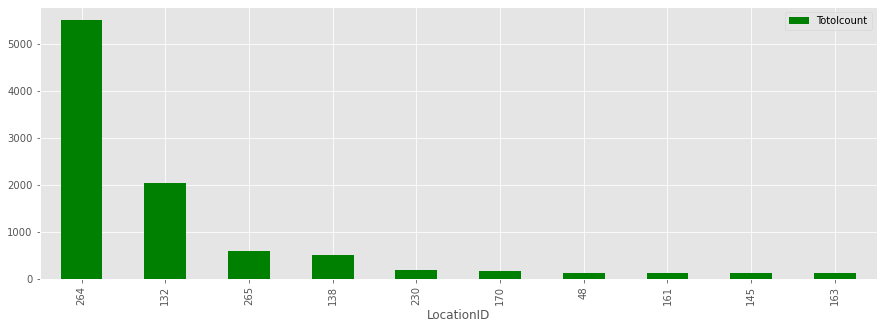

In [103]:
# Location pairing
# So here i am checking both the  PULocationID and DOLocationID 
# where PULocationID == DOLocationID then flag 1 and flag 0 where PULocationID != DOLocationID

neighboured_pairs = (taxi_trip_no_outliers.withColumn(
    'is_pair', f.when(f.col("PULocationID") == f.col("DOLocationID") , 1).otherwise(0))).where(
    f.col("is_pair").isin({1}))


pu_no_outliers = (neighboured_pairs.select(
    "PULocationID")).groupby(
    "PULocationID").count().withColumnRenamed(
    "PULocationID", "LocationID").withColumnRenamed(
    "count", "PUcount")

do_no_outliers = (neighboured_pairs.select(
    "DOLocationID")).groupby(
    "DOLocationID").count().withColumnRenamed(
    "DOLocationID", "LocationID").withColumnRenamed(
    "count", "DOcount"
)

pu_do_join = pu_no_outliers.join(do_no_outliers, on=["LocationID"], how='inner')

df = (
    pu_do_join.withColumn(
        'Totolcount', sum(
            pu_do_join[col] for col in (
                pu_do_join.select("DOcount","PUcount")).columns)
    )
).sort(f.desc("Totolcount"))


print("-------> TOP 10 LOCATION PAIRS COUNT <------------ \n ")
print(f"Total pairs Count ----> {neighboured_pairs.count()} \n" )
df.show(10) # print top to



# parse to pandas df and plot graph
top_ten_location = df.limit(10).toPandas()
top_ten_location.plot(kind='bar',x='LocationID',y='Totolcount', figsize=(15,5), color='#008000')




# Task 3 -

- Calculate the same as in previous step, only lets assume the pair includes values from neighboured numbers i.e. pair (5,5) includes (4,4), (4,5), (5,4), (5,5), (4,6), (6,4), (5,6), (6,5), (6,6)

The step i took to achieve this, 
- First check how the locationIDs are distribute and i figured that LID was just a range of number from 1 - 265
- second, then create this pairs based on the neighboured_pairs obtained above ( where PULocationID == DOLocationID) 

Example : 

| PULocationID | DOLocationID  | PU  | DO  |
| -------------|:-------------:| ---:|:---:|
| 48           | 48            | 47  |  49 |
| 48           | 48            | 49  |  47 |
| 48           | 48            | 47  |  47 |
| 48           | 48            | 49  |  49 |
| 48           | 48            | 47  |  48 |
| 48           | 48            | 49  |  48 |
| 48           | 48            | 48  |  47 |
| 48           | 48            | 48  |  49 |
| 48           | 48            | 48  |  48 |
| 248          | 248           | 247 | 249 |
| 248          | 248           | 249 | 247 |
| 248          | 248           | 247 | 247 |
| 248          | 248           | 249 | 249 |
| 248          | 248           | 247 | 248 |
| 248          | 248           | 249 | 248 |
| 248          | 248           | 248 | 247 |
| 248          | 248           | 248 | 249 |
| 248          | 248           | 248 | 248 |


In [101]:
from functools import reduce
from pyspark.sql import DataFrame

def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

neighboured_pairs = neighboured_pairs.select("trip_distance", "PULocationID", "DOLocationID")

ngh_1 = neighboured_pairs.withColumn(
    'PU', neighboured_pairs.PULocationID - 1).withColumn(
    'DO', neighboured_pairs.DOLocationID - 1
)

ngh_2 = neighboured_pairs.withColumn(
    'PU', neighboured_pairs.PULocationID - 1).withColumn(
    'DO', neighboured_pairs.DOLocationID + 1
)

ngh_3 = neighboured_pairs.withColumn(
    'PU', neighboured_pairs.PULocationID + 1).withColumn(
    'DO', neighboured_pairs.DOLocationID - 1
)

ngh_4 = neighboured_pairs.withColumn(
    'PU', neighboured_pairs.PULocationID + 1).withColumn(
    'DO', neighboured_pairs.DOLocationID + 1
)

ngh_5 = neighboured_pairs.withColumn(
    'PU', neighboured_pairs.PULocationID).withColumn(
    'DO', neighboured_pairs.DOLocationID + 1
)


ngh_6 = neighboured_pairs.withColumn(
    'PU', neighboured_pairs.PULocationID).withColumn(
    'DO', neighboured_pairs.DOLocationID - 1
)

ngh_7 = neighboured_pairs.withColumn(
    'PU', neighboured_pairs.PULocationID + 1).withColumn(
    'DO', neighboured_pairs.DOLocationID 
)


ngh_8 = neighboured_pairs.withColumn(
    'PU', neighboured_pairs.PULocationID - 1).withColumn(
    'DO', neighboured_pairs.DOLocationID
)

ngh_9 = neighboured_pairs.withColumn(
    'PU', neighboured_pairs.PULocationID).withColumn(
    'DO', neighboured_pairs.DOLocationID
)


nearest_ngh = unionAll(ngh_1, ngh_2, ngh_3, ngh_4, ngh_5, ngh_6, ngh_7, ngh_8, ngh_9)

print(f"Total pairs Count ----> {nearest_ngh.count()} \n" )
nearest_ngh.show()



df = nearest_ngh.select(col("PULocationID").alias("LocationID"), 'PU', 'DO')

final_res = (df.groupby('LocationID').count().sort(col("count").desc())).withColumnRenamed(
    "count", "Total_count").limit(10)

final_res.show()



Total pairs Count ----> 58275 

+-------------+------------+------------+---+---+
|trip_distance|PULocationID|DOLocationID| PU| DO|
+-------------+------------+------------+---+---+
|          9.2|         164|         164|163|163|
|         10.1|         264|         264|263|263|
|        20.89|          48|          48| 47| 47|
|         9.37|         264|         264|263|263|
|         7.14|         264|         264|263|263|
|         6.57|         264|         264|263|263|
|         12.6|          50|          50| 49| 49|
|        17.18|         263|         263|262|262|
|          6.4|         264|         264|263|263|
|        10.14|          68|          68| 67| 67|
|         7.69|         264|         264|263|263|
|         9.79|         264|         264|263|263|
|         11.9|          79|          79| 78| 78|
|         6.99|         255|         255|254|254|
|         7.26|         264|         264|263|263|
|        19.65|         138|         138|137|137|
|         13.0|   

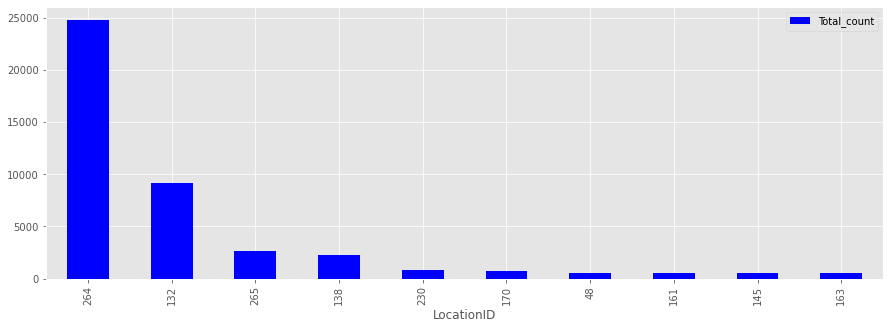

In [102]:
# parse to pandas df and plot graph
final_res = final_res.toPandas()
final_res.plot(kind='bar',x='LocationID',y='Total_count', figsize=(15,5), color='blue')